In [34]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
import matplotlib.style as stl
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image 
import time
import glob
import imageio
import gc
import gdown
from zipfile import ZipFile
import random

import time
from tensorflow import keras
import tensorflow as tf
from keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import SGD, Adam

# Generating Dog Images Using a GAN

This project entails using a GAN, which is comprised of a generator and discriminator, to generate images of dogs from a set of training images that will be feed to the model.

The dataset is downloaded from Kaggle.

In [2]:
print("Images in all-dogs folder: {}".format(len(os.listdir("../KaggleGAN/all-dogs"))))
print("# of Dog breeds: {}".format(len(os.listdir('../KaggleGAN/Annotation'))))

Images in all-dogs folder: 20579
# of Dog breeds: 120


In [10]:
breeds = os.listdir('../KaggleGAN/Annotation/') # list of all breeds
dataset = keras.preprocessing.image_dataset_from_directory(
    "../KaggleGAN/all-dogs", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


Found 20579 files belonging to 1 classes.


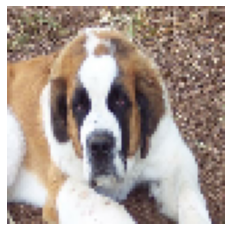

In [8]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int64")[0])
    break

In [9]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 256)         0         
                                                                 
 flatten (Flatten)           (None, 16384)           

In [11]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [12]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [13]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            if i == 0 and epoch % 10 == 0:
                plt.imshow(img)
                plt.show()
            img.save("../KaggleGAN/generated_training_images/generated_img_%03d_%d.png" % (epoch, i))

Epoch 1/150
644/644 [==============================] - ETA: 0s - d_loss: 0.5761 - g_loss: 3.0828

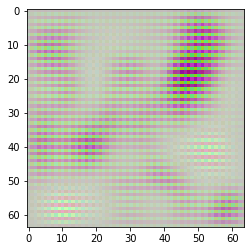

644/644 [==============================] - 129s 200ms/step - d_loss: 0.5761 - g_loss: 3.0828
Epoch 2/150
644/644 [==============================] - 126s 195ms/step - d_loss: 0.6546 - g_loss: 1.4307
Epoch 3/150
644/644 [==============================] - 124s 193ms/step - d_loss: 0.6548 - g_loss: 1.2257
Epoch 4/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.5828 - g_loss: 1.9414
Epoch 5/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.5847 - g_loss: 1.2971
Epoch 6/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6959 - g_loss: 1.7306
Epoch 7/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.5627 - g_loss: 1.4894
Epoch 8/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6472 - g_loss: 1.5162
Epoch 9/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6288 - g_loss: 1.9222
Epoch 10/150
644/644 [==============================] - 126s 196ms/

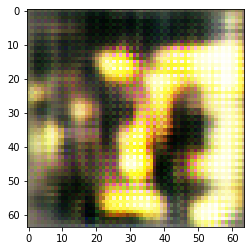

644/644 [==============================] - 123s 191ms/step - d_loss: 0.5655 - g_loss: 1.5162
Epoch 12/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.5590 - g_loss: 1.6349
Epoch 13/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6700 - g_loss: 1.4670
Epoch 14/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6235 - g_loss: 1.5067
Epoch 15/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.5723 - g_loss: 1.4216
Epoch 16/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6447 - g_loss: 1.4169
Epoch 17/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6430 - g_loss: 1.3332
Epoch 18/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.5931 - g_loss: 1.4219
Epoch 19/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6147 - g_loss: 1.3396
Epoch 20/150
644/644 [==============================] - 123

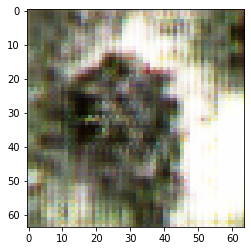

644/644 [==============================] - 123s 190ms/step - d_loss: 0.5926 - g_loss: 1.2362
Epoch 22/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6293 - g_loss: 1.2334
Epoch 23/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6652 - g_loss: 1.4931
Epoch 24/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6837 - g_loss: 1.5335
Epoch 25/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6380 - g_loss: 1.2256
Epoch 26/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6425 - g_loss: 1.2524
Epoch 27/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6384 - g_loss: 1.1295
Epoch 28/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6332 - g_loss: 1.0678
Epoch 29/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6464 - g_loss: 1.2274
Epoch 30/150
644/644 [==============================] - 124

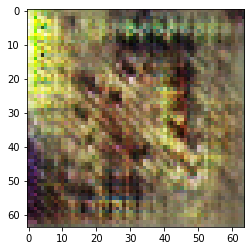

644/644 [==============================] - 123s 191ms/step - d_loss: 0.6859 - g_loss: 1.3771
Epoch 32/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6471 - g_loss: 1.0314
Epoch 33/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6606 - g_loss: 1.0601
Epoch 34/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.7101 - g_loss: 1.4183
Epoch 35/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6189 - g_loss: 1.5078
Epoch 36/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6368 - g_loss: 1.0511
Epoch 37/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6347 - g_loss: 1.3729
Epoch 38/150
644/644 [==============================] - 122s 190ms/step - d_loss: 0.6110 - g_loss: 1.2026
Epoch 39/150
644/644 [==============================] - 127s 197ms/step - d_loss: 0.6467 - g_loss: 1.0546
Epoch 40/150
644/644 [==============================] - 123

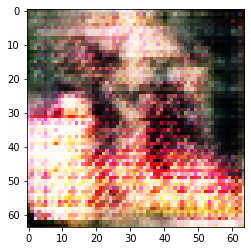

644/644 [==============================] - 122s 190ms/step - d_loss: 0.7065 - g_loss: 1.2819
Epoch 42/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6741 - g_loss: 1.1233
Epoch 43/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6631 - g_loss: 1.1399
Epoch 44/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6302 - g_loss: 1.1462
Epoch 45/150
644/644 [==============================] - 122s 190ms/step - d_loss: 0.6499 - g_loss: 1.2495
Epoch 46/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6775 - g_loss: 1.0293
Epoch 47/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6844 - g_loss: 1.0747
Epoch 48/150
644/644 [==============================] - 122s 190ms/step - d_loss: 0.6757 - g_loss: 1.1826
Epoch 49/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6494 - g_loss: 1.0580
Epoch 50/150
644/644 [==============================] - 123

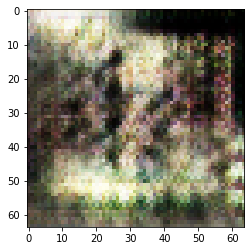

644/644 [==============================] - 122s 190ms/step - d_loss: 0.6816 - g_loss: 1.0482
Epoch 52/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6720 - g_loss: 1.1956
Epoch 53/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6503 - g_loss: 1.0478
Epoch 54/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6666 - g_loss: 1.0485
Epoch 55/150
644/644 [==============================] - 122s 190ms/step - d_loss: 0.6255 - g_loss: 1.2875
Epoch 56/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.7225 - g_loss: 1.2076
Epoch 57/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6742 - g_loss: 1.1957
Epoch 58/150
644/644 [==============================] - 124s 190ms/step - d_loss: 0.6652 - g_loss: 1.0622
Epoch 59/150
644/644 [==============================] - 125s 191ms/step - d_loss: 0.6288 - g_loss: 1.1628
Epoch 60/150
644/644 [==============================] - 124

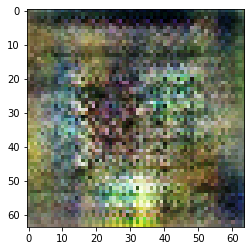

644/644 [==============================] - 123s 190ms/step - d_loss: 0.6708 - g_loss: 1.2032
Epoch 62/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6780 - g_loss: 1.1201
Epoch 63/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6957 - g_loss: 1.1144
Epoch 64/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6425 - g_loss: 1.1487
Epoch 65/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6589 - g_loss: 1.2017
Epoch 66/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6342 - g_loss: 1.0900
Epoch 67/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6665 - g_loss: 1.2504
Epoch 68/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6267 - g_loss: 1.2071
Epoch 69/150
644/644 [==============================] - 127s 198ms/step - d_loss: 0.6729 - g_loss: 1.1149
Epoch 70/150
644/644 [==============================] - 124

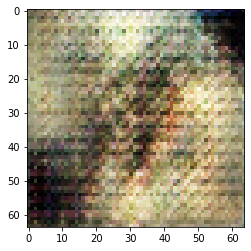

644/644 [==============================] - 123s 192ms/step - d_loss: 0.6462 - g_loss: 1.2879
Epoch 72/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6335 - g_loss: 1.2429
Epoch 73/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6508 - g_loss: 1.1010
Epoch 74/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6602 - g_loss: 1.2386
Epoch 75/150
644/644 [==============================] - 122s 190ms/step - d_loss: 0.6590 - g_loss: 1.4582
Epoch 76/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6850 - g_loss: 1.1901
Epoch 77/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6360 - g_loss: 1.0860
Epoch 78/150
644/644 [==============================] - 122s 190ms/step - d_loss: 0.6586 - g_loss: 1.1767
Epoch 79/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6650 - g_loss: 1.2751
Epoch 80/150
644/644 [==============================] - 123

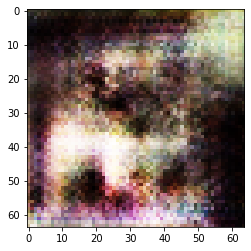

644/644 [==============================] - 122s 190ms/step - d_loss: 0.6770 - g_loss: 1.0602
Epoch 82/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6908 - g_loss: 1.3969
Epoch 83/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6352 - g_loss: 1.2298
Epoch 84/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6218 - g_loss: 1.3863
Epoch 85/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6644 - g_loss: 1.3352
Epoch 86/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6084 - g_loss: 1.3839
Epoch 87/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6296 - g_loss: 1.3912
Epoch 88/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6184 - g_loss: 1.4581
Epoch 89/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.5980 - g_loss: 1.2443
Epoch 90/150
644/644 [==============================] - 124

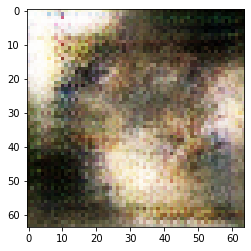

644/644 [==============================] - 123s 190ms/step - d_loss: 0.6520 - g_loss: 1.2560
Epoch 92/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6449 - g_loss: 1.2100
Epoch 93/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6940 - g_loss: 1.3595
Epoch 94/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6406 - g_loss: 1.1619
Epoch 95/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6431 - g_loss: 1.1807
Epoch 96/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6643 - g_loss: 1.2223
Epoch 97/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6385 - g_loss: 1.1735
Epoch 98/150
644/644 [==============================] - 127s 197ms/step - d_loss: 0.6888 - g_loss: 1.2121
Epoch 99/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6935 - g_loss: 1.2020
Epoch 100/150
644/644 [==============================] - 12

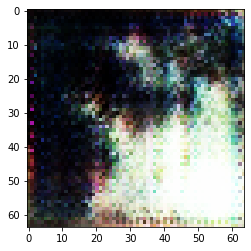

644/644 [==============================] - 122s 190ms/step - d_loss: 0.6615 - g_loss: 1.2247
Epoch 102/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6811 - g_loss: 1.1256
Epoch 103/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6327 - g_loss: 1.2884
Epoch 104/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6626 - g_loss: 1.2254
Epoch 105/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6363 - g_loss: 1.4121
Epoch 106/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6732 - g_loss: 1.3501
Epoch 107/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6333 - g_loss: 1.2388
Epoch 108/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6342 - g_loss: 1.2341
Epoch 109/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6426 - g_loss: 1.1989
Epoch 110/150
644/644 [============================

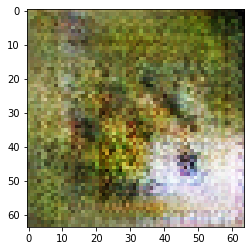

644/644 [==============================] - 123s 191ms/step - d_loss: 0.7146 - g_loss: 1.2098
Epoch 112/150
644/644 [==============================] - 124s 193ms/step - d_loss: 0.6816 - g_loss: 1.2252
Epoch 113/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6433 - g_loss: 1.2213
Epoch 114/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6521 - g_loss: 1.1132
Epoch 115/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.7279 - g_loss: 1.0906
Epoch 116/150
644/644 [==============================] - 127s 194ms/step - d_loss: 0.6833 - g_loss: 1.1209
Epoch 117/150
644/644 [==============================] - 125s 193ms/step - d_loss: 0.6673 - g_loss: 1.2091
Epoch 118/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6966 - g_loss: 1.0182
Epoch 119/150
644/644 [==============================] - 125s 194ms/step - d_loss: 0.6792 - g_loss: 1.1601
Epoch 120/150
644/644 [============================

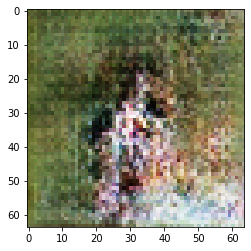

644/644 [==============================] - 124s 193ms/step - d_loss: 0.6753 - g_loss: 1.0525
Epoch 122/150
644/644 [==============================] - 125s 194ms/step - d_loss: 0.6755 - g_loss: 1.2548
Epoch 123/150
644/644 [==============================] - 125s 193ms/step - d_loss: 0.6609 - g_loss: 1.1190
Epoch 124/150
644/644 [==============================] - 125s 193ms/step - d_loss: 0.6721 - g_loss: 1.1328
Epoch 125/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.7106 - g_loss: 1.1563
Epoch 126/150
644/644 [==============================] - 125s 193ms/step - d_loss: 0.7032 - g_loss: 1.1230
Epoch 127/150
644/644 [==============================] - 127s 198ms/step - d_loss: 0.6511 - g_loss: 1.0689
Epoch 128/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6540 - g_loss: 1.1121
Epoch 129/150
644/644 [==============================] - 124s 193ms/step - d_loss: 0.7031 - g_loss: 1.1558
Epoch 130/150
644/644 [============================

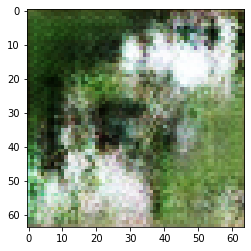

644/644 [==============================] - 123s 190ms/step - d_loss: 0.6917 - g_loss: 1.1400
Epoch 132/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6874 - g_loss: 1.0943
Epoch 133/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6616 - g_loss: 1.0436
Epoch 134/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.7280 - g_loss: 1.0635
Epoch 135/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6755 - g_loss: 0.9989
Epoch 136/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6840 - g_loss: 1.0430
Epoch 137/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6772 - g_loss: 1.0205
Epoch 138/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6987 - g_loss: 1.0571
Epoch 139/150
644/644 [==============================] - 123s 191ms/step - d_loss: 0.6689 - g_loss: 1.0346
Epoch 140/150
644/644 [============================

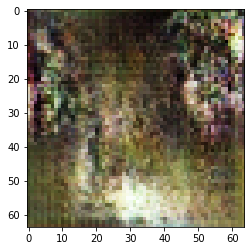

644/644 [==============================] - 123s 190ms/step - d_loss: 0.6780 - g_loss: 0.9673
Epoch 142/150
644/644 [==============================] - 123s 192ms/step - d_loss: 0.6682 - g_loss: 1.0831
Epoch 143/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6870 - g_loss: 1.0138
Epoch 144/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6623 - g_loss: 1.0855
Epoch 145/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.6863 - g_loss: 0.9439
Epoch 146/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.7054 - g_loss: 1.2002
Epoch 147/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6856 - g_loss: 1.0881
Epoch 148/150
644/644 [==============================] - 123s 190ms/step - d_loss: 0.7302 - g_loss: 1.0631
Epoch 149/150
644/644 [==============================] - 124s 192ms/step - d_loss: 0.6689 - g_loss: 0.9658
Epoch 150/150
644/644 [============================

In [15]:
epochs = 150 # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=15, latent_dim=latent_dim)]
)

Now that our model has been created and compiled, lets generate 100 images and take a look at them. 

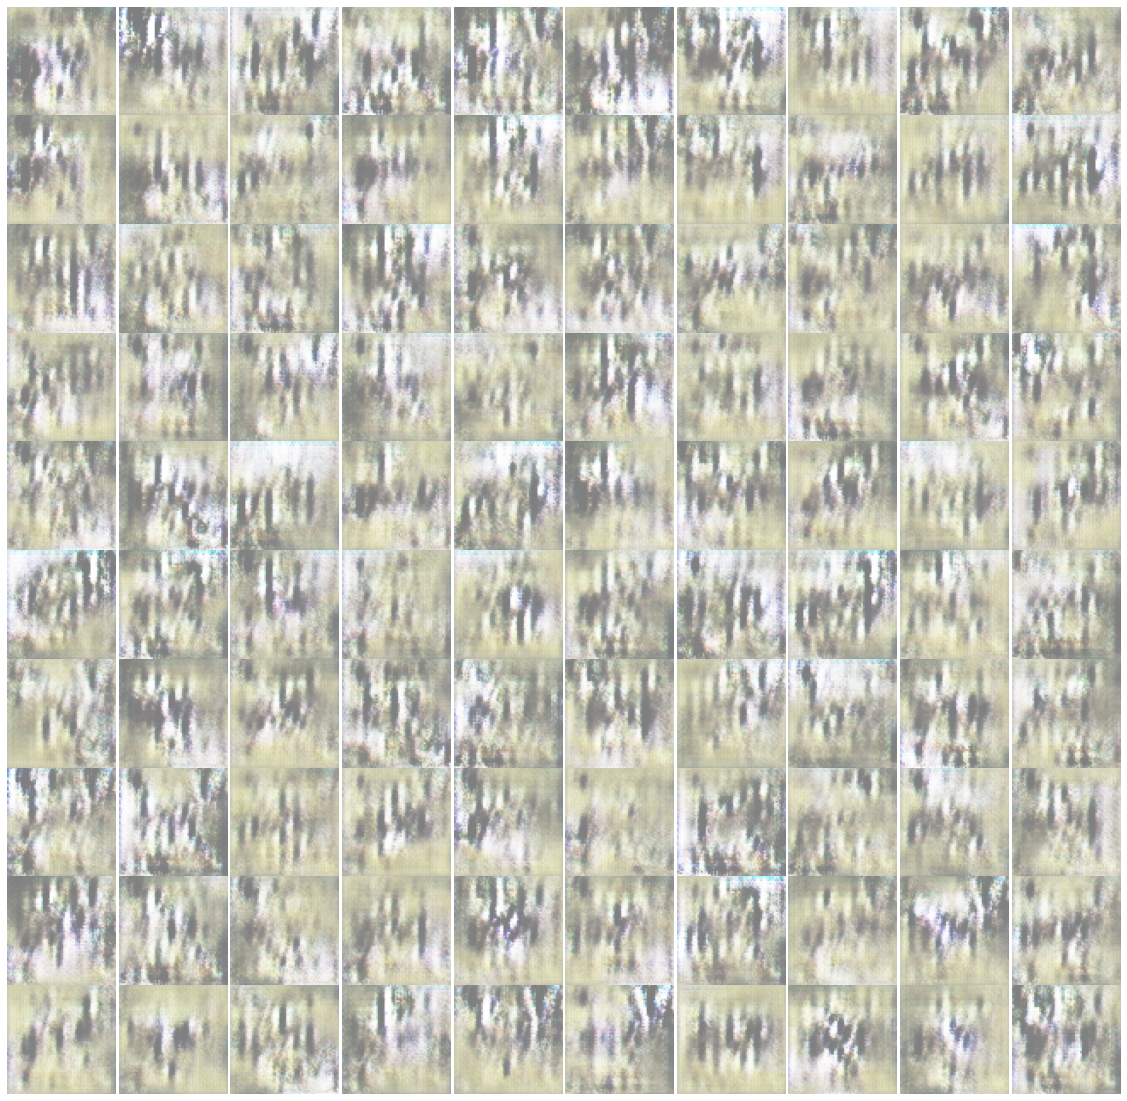

In [102]:
def generate_latent_points(latent_dim, n_samples):
    return tf.random.truncated_normal((n_samples,latent_dim))

train_gen = gan.generator
seed = generate_latent_points(128, 100)
labs = tf.cast(240*tf.random.uniform((128,1)),tf.int8)
predictions = train_gen(seed, training=False)
plt.figure(figsize=(20,20))
plt.subplots_adjust(wspace=0,hspace=0)
for k in range(100):
    plt.subplot(10,10,k+1)
    plt.imshow( (predictions[k,:,:,:]+1.)/2. )
    plt.axis('off')
plt.show()

Looking at the images above, it doesn't look like any dogs were generated from the model. They mostly look like the model picked up too much extra information from the background from the training images.

Next, lets look at a random selection of saved training images from compiling the GAN.

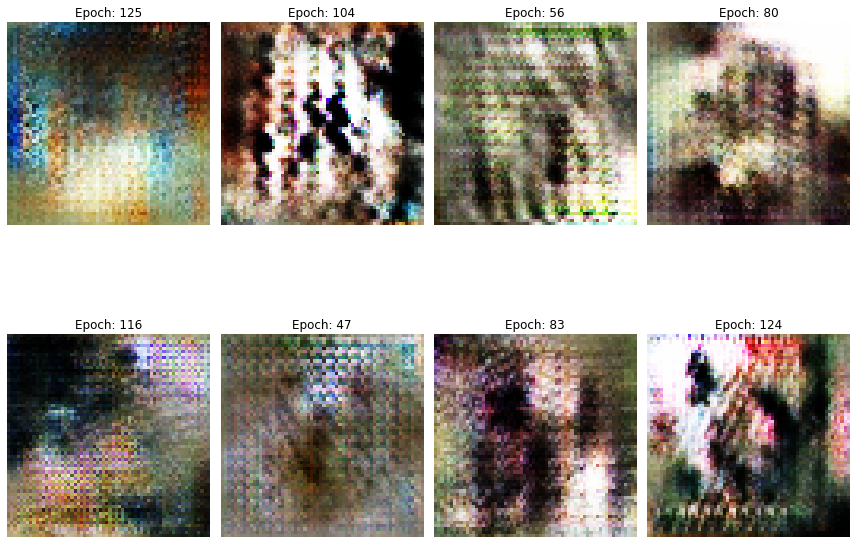

In [49]:
path = '../KaggleGAN/generated_training_images/'
img_name = sorted(os.listdir('../KaggleGAN/generated_training_images/'))
img_paths = []
for i in img_name:
    img_paths.append(path + i)
fig,((ax1, ax2, ax3, ax4),(ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(12, 10))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]
li = random.sample(range(0,2250), 8)
for i in range(8):
    img = mpimg.imread(img_paths[li[i]])
    ax[i].imshow(img)
    ax[i].set_title("Epoch: {}".format(round(li[i]/15)))
    ax[i].axis('off')
plt.tight_layout()
plt.show()

In [52]:
trained_gen = gan.generator

Now, lets create the zip file that would usually be uploaded to Kaggle. Since the competition is not accepting submissions, this is the last step, can't do anything beyond this.

In [53]:
z = zipfile.PyZipFile('images.zip', mode='w')

In [55]:
for k in range(10000):
    generated_image = trained_gen(tf.random.normal([1, 128]), training=False)
    f = str(k)+'.png'
    img = ((generated_image[0,:,:,:]+1.)/2.).numpy()
    tf.keras.preprocessing.image.save_img(
        f,
        img,
        scale=True
    )
    z.write(f); os.remove(f)
z.close()

## Conclusion and Analysis

Looking at the images our GAN generated in the 10 by 10 grid above, they don't look like our model did a great job of generating images of dogs. This could be because of lots of reasons, the generator and discriminator might be too simple. The model might not have gone through as many epochs as it needed to. We may not have prepped the images as much as we needed to, like cropping them to just the dog in the image. The size of the images that we put in the model being 64x64 might not have been as detailed as they could of been, this is due to a lack in time and computational power, increasing the size of the images would have increased the time dramatically needed to compile our GAN. 

Since the competition ended in 2019, we are no longer able to submit the images we have generated to get our scores. There are some notebooks in kaggle that provide a function to compute the scores ourselves, but none that I could find are compatiable with TensorFlow 2.X, so I was unable to run our images through to calculate our MiFID Score. 

All in all, for the first GAN we have created, we didn't do a bad job. It would have been nice to get more detailed and accurate images, but getting the model to compile and run the images was still a very valuable experience. 

### Refrences

    https://www.kaggle.com/code/wendykan/demo-mifid-metric-for-dog-image-generation-comp/notebook
    https://www.kaggle.com/code/cdeotte/supervised-generative-dog-net/notebook#Supervised-Generative-Dog-Network
    https://www.kaggle.com/code/jesucristo/gan-introduction#Introduction
    https://www.tensorflow.org/tutorials/generative/dcgan
    https://keras.io/examples/generative/conditional_gan/